In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

from jax import vmap

def plot_contour(f):
    vf = vmap(f)
    x1s = jnp.linspace(-1.5, 1.5, 100)
    x2s = jnp.linspace(-1.5, 1.5, 100)
    X1, X2 = jnp.meshgrid(x1s, x2s)
    X = jnp.vstack([X1.ravel(), X2.ravel()]).T
    Z = vf(X).reshape(X1.shape)
    c = plt.contour(X1, X2, Z, 30)
    plt.colorbar(c, label='$f(x)$')

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Gradient descent - different initializations')

def plot_path(i, x_list):
    plt.quiver(x_list[:-1, 0], x_list[:-1, 1], x_list[1:, 0] - x_list[:-1, 0], x_list[1:, 1] - x_list[:-1, 1], 
               scale_units='xy', angles='xy', scale=1, color=plt.cm.tab10(i), width=0.004, headwidth=3, headlength=4)

# `Optax` - Optimizers in JAX

I am not going to code any more optimizers from scratch. I am going to use [optax](www.github.com/deepmind/optax) from DeepMind. It has everything we need and more.
Let's see how we can do the same things as before.

The first piece of code is the same for pretty much any optimizer you want to use:

In [57]:
import jax.numpy as jnp
from jax import grad, jit
import optax


# And typically, we organizer the training loop like this
def solve(params, optimizer, opt_state=None, n_iter=100, return_path=False):
    
    # This is the step of the optimizer.
    # It is always a good idea to jit this function.
    # Here we also define it inside the solve function.
    @jit
    def step(opt_state, params):
        g = grad(f)(params)
        # This is the update step of the optimizer
        # It needs the gradient and the optimizer state
        updates, opt_state = optimizer.update(g, opt_state)
        # Update the parameters (This works on any pytree)
        params = optax.apply_updates(params, updates)
        return opt_state, params

    if opt_state is None:
        opt_state = optimizer.init(params)
    path = [params]
    for i in range(100):
        opt_state, params = step(opt_state, params)
        path.append(params.copy())
    if return_path:
        return jnp.stack(path)
    return params

Let's try it:

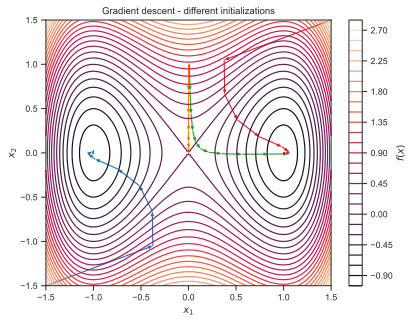

In [58]:
# The function we want to minimize
f = lambda x: x[0] ** 4 - 2.0 * x[0] ** 2 + x[1] ** 2

# The optimizer
optimizer = optax.sgd(
    learning_rate=0.1,  # this is our alpha
    momentum=0.5,       # this is our beta
    nesterov=True       # use Nesterov or not
)

x0s = jnp.array(
    [
        [-1.5, -1.5], 
        [0.0, 1.0],
        [0.01, 1.0],
        [1.5, 1.5]
    ]
)

plot_contour(f)

for i, x0 in enumerate(x0s):
    path = solve(x0, optimizer, n_iter=100, return_path=True)
    plot_path(i, path)

Okay. Now observe again that when we start right above the saddle point, we get stuck in the saddle point. Recall, that this is not ever going to happen because when we start at random it is impossible to start right above the saddle point.
However, I am going to fix this by adding a little bit of initial momentum. Not because it is necessary, but because it is a good excuse to show you how `optax` works.

Here we go. First, let's initialize the optimizer outside of the loop:

In [66]:
x0 = jnp.array([0.0, 1.0])

init_state = optimizer.init(x0)

init_state

(TraceState(trace=Array([0., 0.], dtype=float32)), EmptyState())

In [75]:
g = grad(f)(x0)

In [76]:
g

Array([0., 2.], dtype=float32)

In [79]:
optimizer.update(g, init_state)

(Array([-0. , -0.3], dtype=float32),
 (TraceState(trace=Array([0., 2.], dtype=float32)), EmptyState()))

Observe that the init state is a tuple. 
The first element is a momentum vector.
Let's make a new initial state so that there is a bit of momentum in the positive x direction:

In [85]:
new_init_state = (
    optax.TraceState(
        trace=jnp.array([0.1, 0.0])
    ),
    init_state[1]
)
new_init_state

(TraceState(trace=Array([0.1, 0. ], dtype=float32)), EmptyState())

Let's start the optimizer from there:

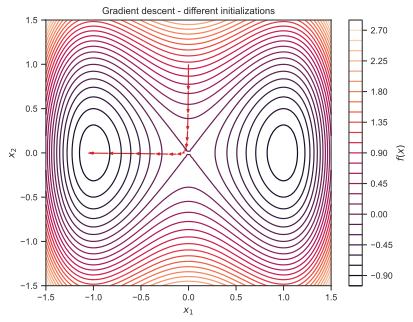

In [86]:
path = solve(
    x0,
    optimizer,
    opt_state=new_init_state,
    n_iter=100,
    return_path=True
)

ax = plot_contour(f)
plot_path(i, path)

And now it escapes the saddle point.